<img src=../figures/Brown_logo.svg width=50%>

## Data-Driven Design & Analyses of Structures & Materials (3dasm)

## Lecture 10

### Miguel A. Bessa | <a href = "mailto: miguel_bessa@brown.edu">miguel_bessa@brown.edu</a>  | Associate Professor

**What:** A lecture of the "3dasm" course

**Where:** This notebook comes from this [repository](https://github.com/bessagroup/3dasm_course)

**Reference for entire course:** Murphy, Kevin P. *Probabilistic machine learning: an introduction*. MIT press, 2022. Available online [here](https://probml.github.io/pml-book/book1.html)

**How:** We try to follow Murphy's book closely, but the sequence of Chapters and Sections is different. The intention is to use notebooks as an introduction to the topic and Murphy's book as a resource.
* If working offline: Go through this notebook and read the book.
* If attending class in person: listen to me (!) but also go through the notebook in your laptop at the same time. Read the book.
* If attending lectures remotely: listen to me (!) via Zoom and (ideally) use two screens where you have the notebook open in 1 screen and you see the lectures on the other. Read the book.

**Optional reference (the "bible" by the "bishop"... pun intended 😆) :** Bishop, Christopher M. *Pattern recognition and machine learning*. Springer Verlag, 2006.

**References/resources to create this notebook:**
* [Car figure](https://korkortonline.se/en/theory/reaction-braking-stopping/)

Apologies in advance if I missed some reference used in this notebook. Please contact me if that is the case, and I will gladly include it here.

## **OPTION 1**. Run this notebook **locally in your computer**:
1. Confirm that you have the '3dasm' mamba (or conda) environment (see Lecture 1).
2. Go to the 3dasm_course folder in your computer and pull the last updates of the [repository](https://github.com/bessagroup/3dasm_course):
```
git pull
```
    - Note: if you can't pull the repo due to conflicts (and you can't handle these conflicts), use this command (with **caution**!) and your repo becomes the same as the one online:
```
git reset --hard origin/main
```
3. Open command window and load jupyter notebook (it will open in your internet browser):
```
jupyter notebook
```
5. Open notebook of this Lecture and choose the '3dasm' kernel.

## **OPTION 2**. Use **Google's Colab** (no installation required, but times out if idle):

1. go to https://colab.research.google.com
2. login
3. File > Open notebook
4. click on Github (no need to login or authorize anything)
5. paste the git link: https://github.com/bessagroup/3dasm_course
6. click search and then click on the notebook for this Lecture.

In [1]:
# Basic plotting tools needed in Python.

import matplotlib.pyplot as plt # import plotting tools to create figures
import numpy as np # import numpy to handle a lot of things!
from IPython.display import display, Math # to print with Latex math

%config InlineBackend.figure_format = "retina" # render higher resolution images in the notebook
plt.rcParams["figure.figsize"] = (8,4) # rescale figure size appropriately for slides

## Outline for today

* Linear models for regression: Practical tutorial (**Part II**: noiseless vs. noisy datasets; train/test dataset split; multi-dimensional example)
    - Influence of noise, i.e. uncertainty
    - Importance of train/test split
    - A first multi-dimensional example

**Reading material**: This notebook + Chapter 11

In [2]:
from sklearn.linear_model import LinearRegression # For Least Squares Regression
from sklearn.preprocessing import PolynomialFeatures # For Polynomial basis functions
from sklearn.pipeline import make_pipeline # to link different objects

## Example 2: linear model for a noiseless problem

Consider now a problem **not governed** by a polynomial law and without uncertainty.

Let's consider the function $x\sin(x)$ in the domain $x\in[0,10]$.

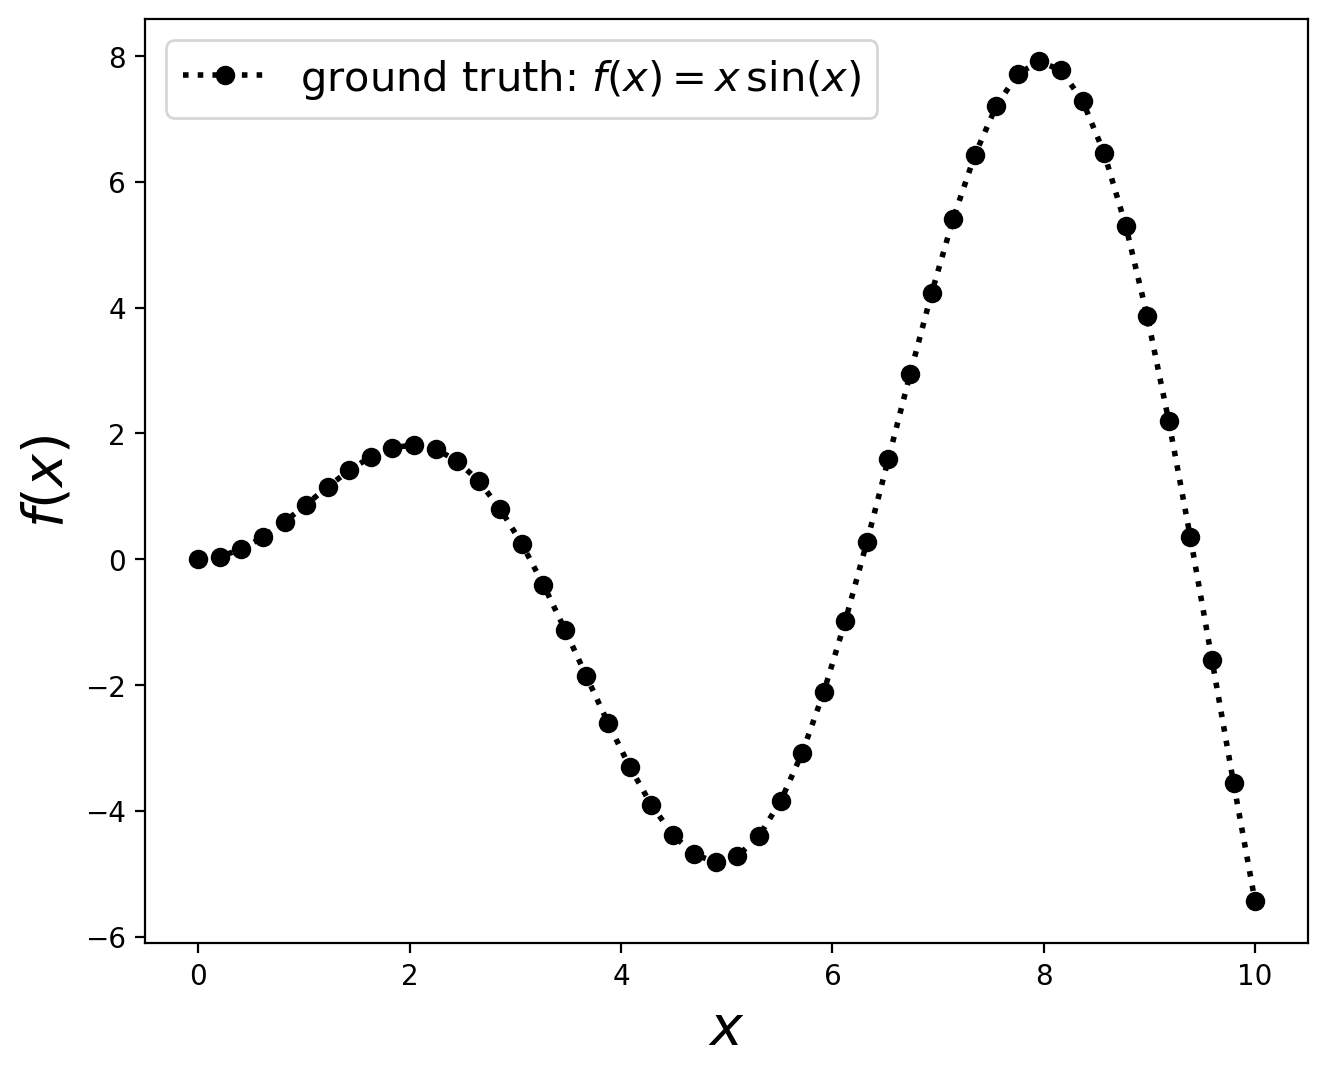

In [3]:
# 1. Define the function f(x) = x sin(x)
def f(x):
    return x * np.sin(x)
# 2. Create a vector of 50 points that are uniformly spaced between 0 and 10
n_data = 50 # number of points for plotting the function
x_data = np.linspace(0, 10, n_data) # uniformly spaced points
# 3. Compute the output vector:
y_data = f(x_data)
# 4. Plot the function and the data
fig1, ax1 = plt.subplots() # This opens a new figure
# Plot points and interpolate them:
ax1.plot(x_data, y_data, 'ko:', markersize=6, linewidth=2,label=u'ground truth: $f(x) = x\, \sin(x)$')
ax1.set_xlabel('$x$', fontsize=20) # label of the x axis
ax1.set_ylabel('$f(x)$', fontsize=20) # label of the y axis
ax1.legend(loc='upper left', fontsize=15) # plot legend in the upper left corner
fig1.set_size_inches(7.5, 6) # scale figure to be taller

With lots of data, even linear interpolation between the points can approximate the function well.

However, what if we use just a few points from our dataset x_data?

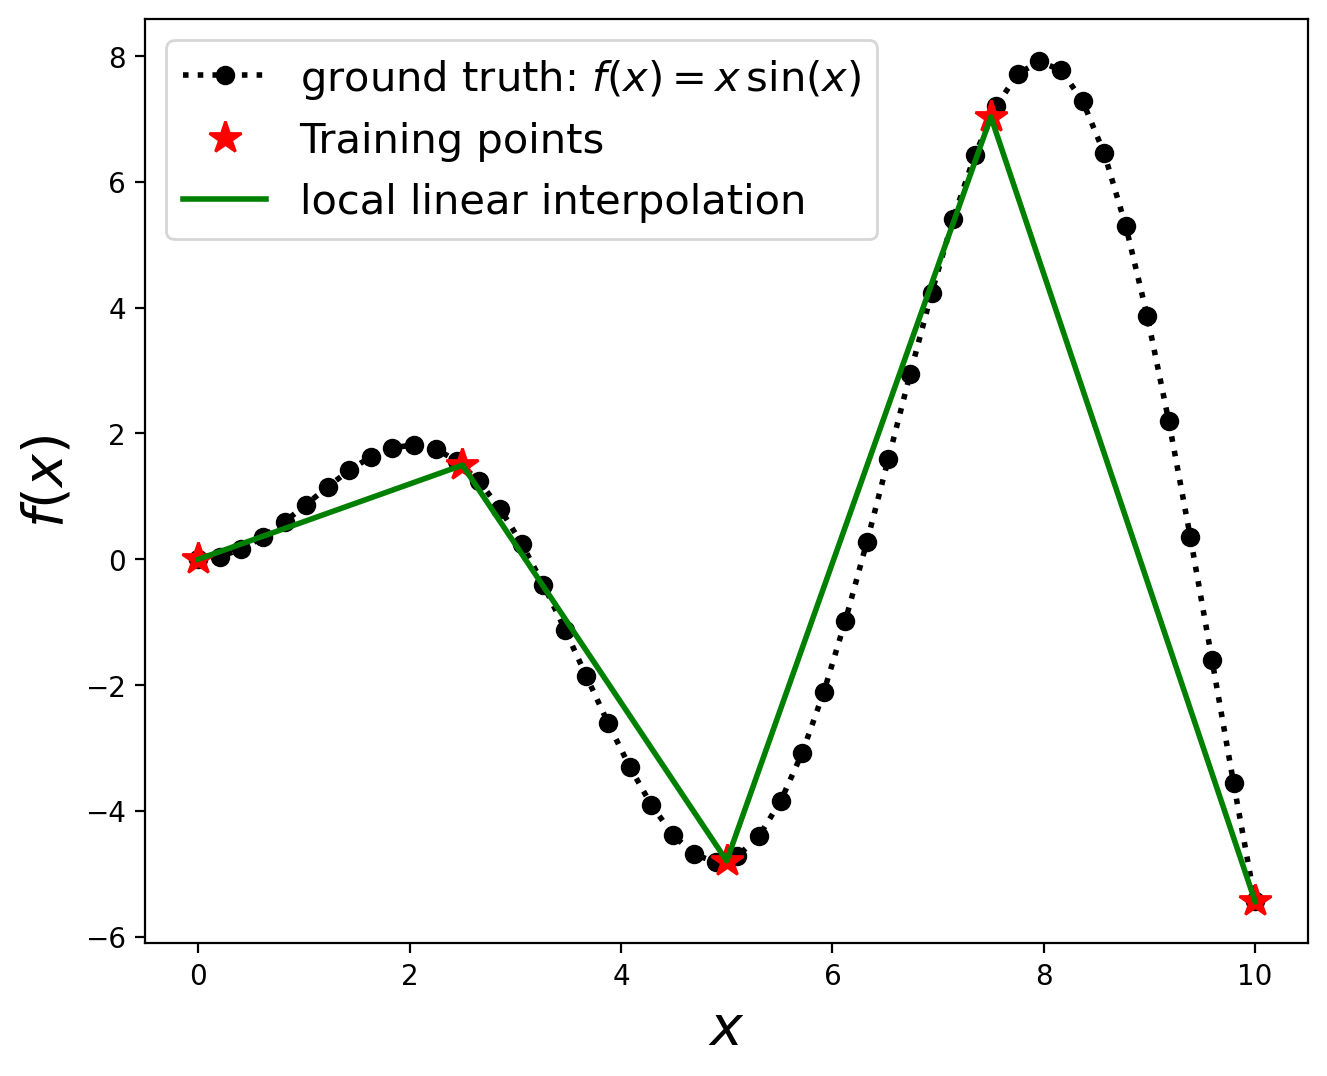

In [4]:
n_train = 5 # points to train the algorithm
x_train = np.linspace(0, 10, n_train) # 5 points uniformly distributed
y_train = f(x_train)
ax1.plot(x_train, y_train, 'r*', markersize=12,label="Training points") # Markers locating training points
ax1.plot(x_train, y_train, 'g-', linewidth=2, label=u'local linear interpolation') # linear interpolation
ax1.legend(loc='upper left', fontsize=15) # replot legend
fig1 # replot fig1 now overlaying the plot in the previous cell

This is called local interpolation because each line only depends on the two points it is connecting (not on the other points).

* This is not an ML model! It's different from the linear model we created for the car stopping distance problem.

So, let's train a linear ML model using a polynomial of degree 4 as basis function for this example.

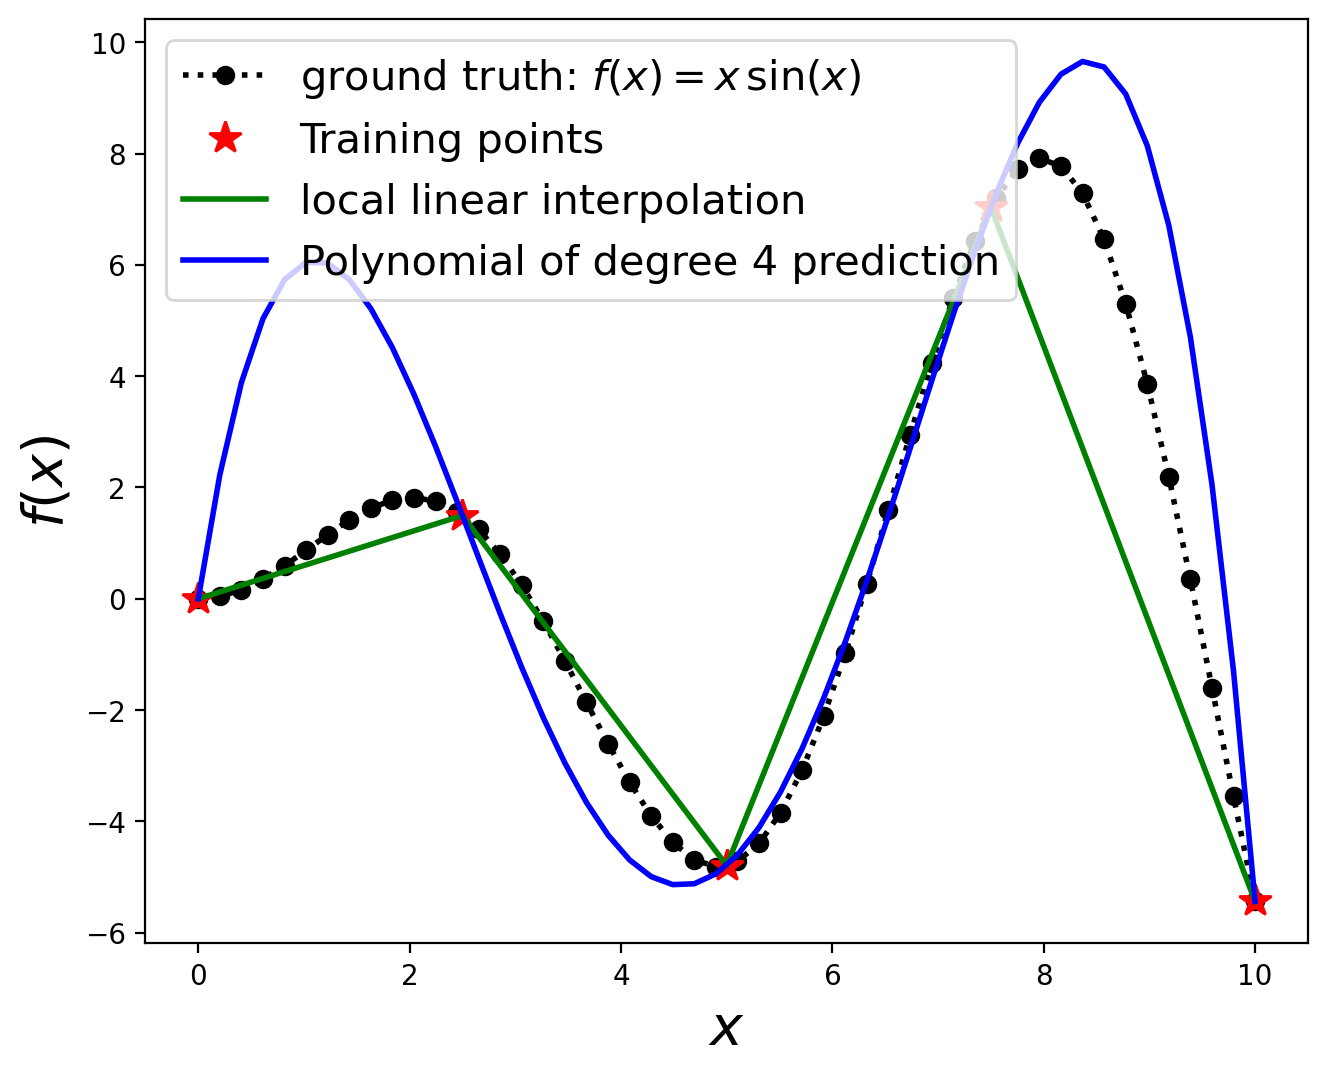

In [5]:
degree = 4 # degree of polynomial

poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression()) # model

X_train = np.reshape(x_train, (-1, 1)) # convert input vector into 2d array

poly_model.fit(X_train,y_train) # fit the polynomial to our 5 training points
#y_pred = poly_model.predict(X_train) # prediction of our polynomial

X_data = np.reshape(x_data, (-1, 1)) # Don't forget to convert to a 2d array
y_pred = poly_model.predict(X_data) # prediction our model for all 50 data points

# Plot x_data and prediction as a blue line:
ax1.plot(x_data, y_pred, 'b-', linewidth=2, label="Polynomial of degree %d prediction" % degree)

# Replot figure and legend:
ax1.legend(loc='upper left', fontsize=15)
fig1

Our polynomial (blue) is clearly different to the function that we want to "learn", i.e. $x \sin(x)$.

How do we evaluate the quality of our approximation?

* By evaluating the error of our polynomial model in the points that we didn't use in the fit.

Two common metrics are $R^2$ and $\text{MSE}$ (you will have to search for them and explain them!)

In [6]:
# Import error metrics:
from sklearn.metrics import mean_squared_error, r2_score

# Compute MSE and R2 for the polynomial model we fitted
mse_value = mean_squared_error(y_data, y_pred)
r2_value = r2_score(y_data, y_pred)

print('MSE for polynomial = ', mse_value)
print('R2 score for polynomial = ', r2_value)

MSE for polynomial =  5.826961574277652
R2 score for polynomial =  0.5786918607519673


As expected, these predictions are not great because:

* We want $\text{MSE}$ to be as low as possible

* The closer $R^2$ is to 1.0 the better

You will dive deeper into this in **Homework 4**.

## Example 3: linear model for noisy datasets

Let's consider one last case where we perturb the function of Example 2 $f(x) = x\sin(x)$ with noise.

* This is similar to what happens in the car stopping distance problem.

* Here, the difference is that at every point the noise is random (not as predictable as before)

Let's "fabricate" such dataset.

In [7]:
seed = 1987 # set a random seed so that everyone gets the same result
np.random.seed(seed)

# Let's perturb every y_data point with Gaussian noise
random_std = 0.5 + 1.0 * np.random.random(y_data.shape)

# Then, take the random value for STD from 0.5 to 1.5 for each
# data point and create noise following a Gaussian distribution with
# that STD at that point:
noise = np.random.normal(0, random_std)

# The perturbed data becomes:
y_noisy_data = y_data + noise

For comparison, we plot the noisy data with the noiseless function that we would like to discover $x \sin(x)$:

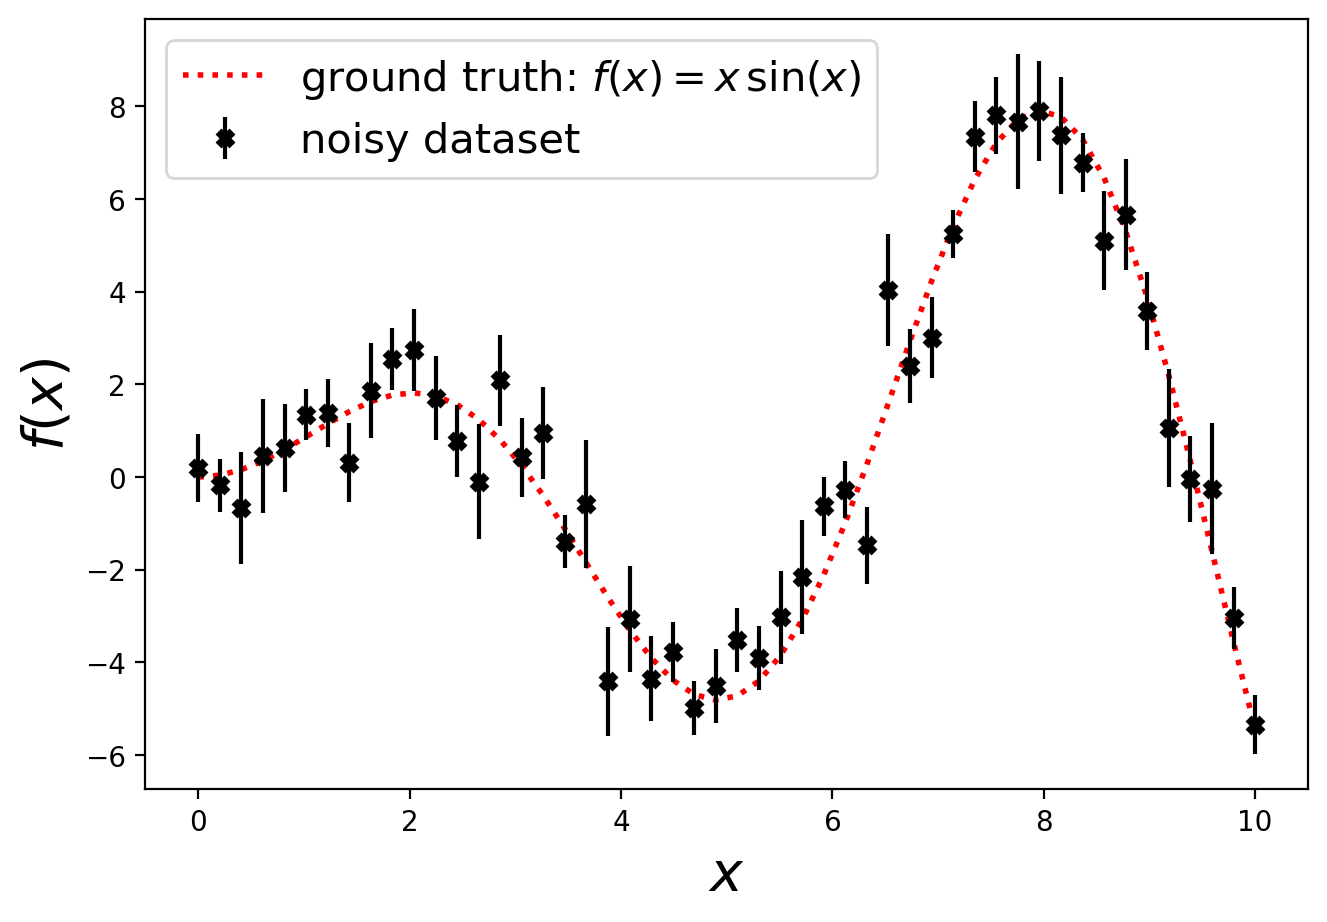

In [8]:
fig2, ax2 = plt.subplots() # This opens a new figure

# Plot the noiseless function ("the ground thruth")
ax2.plot(x_data, y_data, 'r:', linewidth=2,
         label=u'ground truth: $f(x) = x\,\sin(x)$')

# Plot the noisy dataset that we are given:
plt.errorbar(x_data, y_noisy_data, random_std, fmt='kX',
             markersize=6, label=u'noisy dataset')

ax2.set_xlabel('$x$', fontsize=20) # label of the x axis
ax2.set_ylabel('$f(x)$', fontsize=20) # label of the y axis
ax2.legend(loc='upper left', fontsize=15) # plot legend in the upper left corner
fig2.set_size_inches(7.5, 5) # scale figure to be taller

Note a couple of things:

* The black "x" marks the actual measured value.

* The black bars indicate the noise in each data point (each data point has a different noise value). Formally, we call this aleatoric uncertainty.
    - In the plot, I centered the error bars around the measured value. Note that the bars do not have the same length (different standard deviation).

## Important note on data preprocessing

Usually, when we are given a dataset we need to find a way to **train** and **test** our model using that data.

However, to test our model we have to use data that we have not used in training, otherwise we would be cheating!

This is done by splitting the dataset (in this case x_data) into two sets:

1. **Training** set (for example: 75% of the dataset)


2. **Test** set with the remaining points of the dataset

Scikit-learn has a very easy way of doing this:

In [9]:
from sklearn.model_selection import train_test_split

X_data = np.reshape(x_data,(-1,1)) # a 2D array that scikit-learn likes
# Let's split the data points into 10% for the training set (5 points)
# and the rest for the test set:
X_train, X_test, y_train, y_test = train_test_split(X_data,
                                    y_noisy_data, test_size=0.90,
                                    random_state=seed)

Note that the train_test_split module of scikit-learn picks points pseudo-randomly according to the random_state seed value.

Let's visualize the training and testing sets:

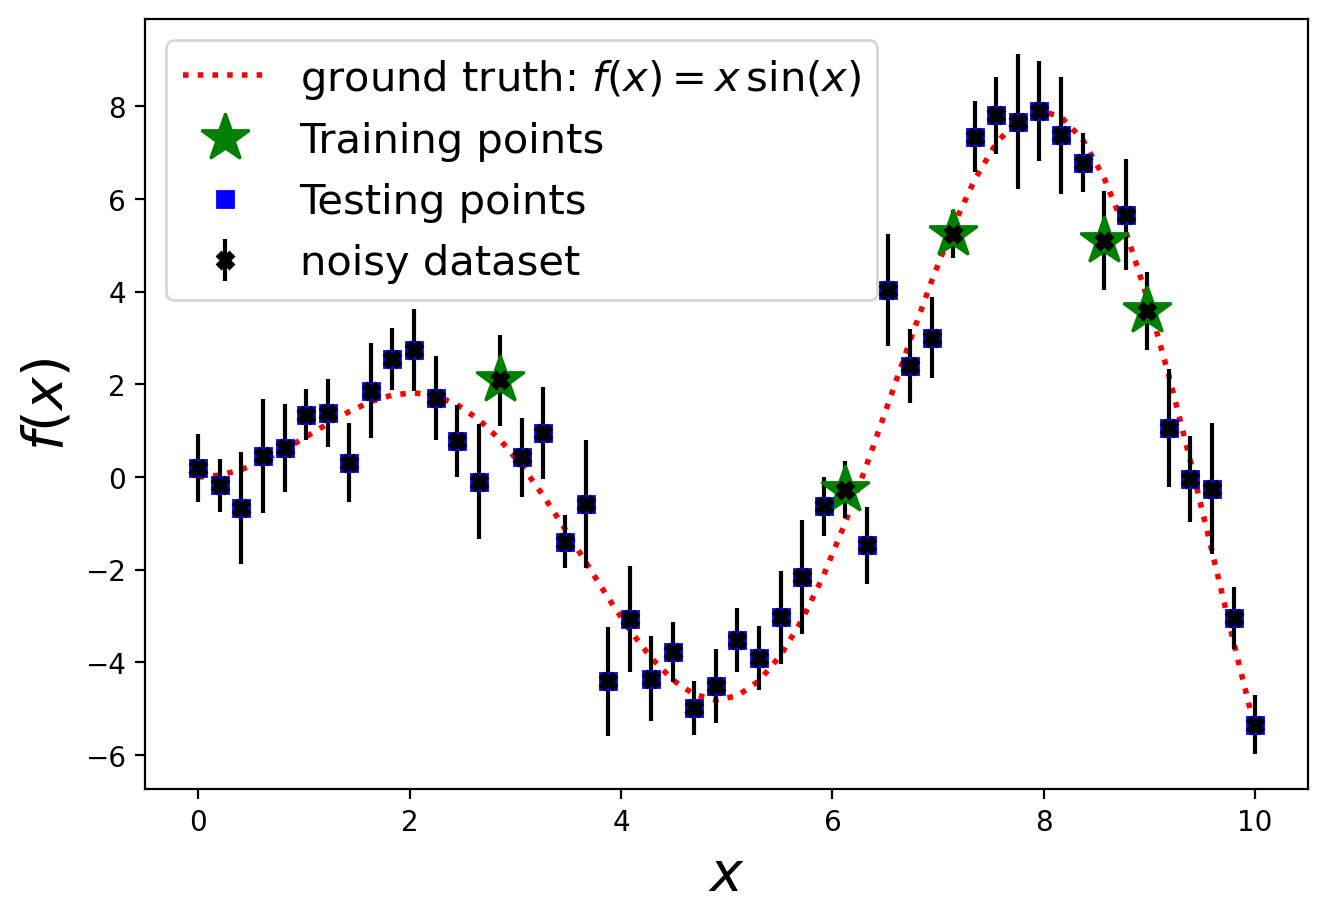

In [10]:
x_train = X_train[:] # converting back to 1D array for plotting
x_test = X_test[:] # converting back to 1D array for plotting
# Plot the noisy training dataset:
ax2.plot(x_train, y_train, 'g*', markersize=18, label="Training points") # Markers locating training points
ax2.plot(x_test, y_test, 'bs', markersize=6,label="Testing points") # Markers locating training points
ax2.set_xlabel('$x$', fontsize=20) # label of the x axis
ax2.set_ylabel('$f(x)$', fontsize=20) # label of the y axis
ax2.legend(loc='upper left', fontsize=15) # plot legend in the upper left corner
fig2

Let's create a new figure with less clutter by just plotting the ground truth function and the training points.

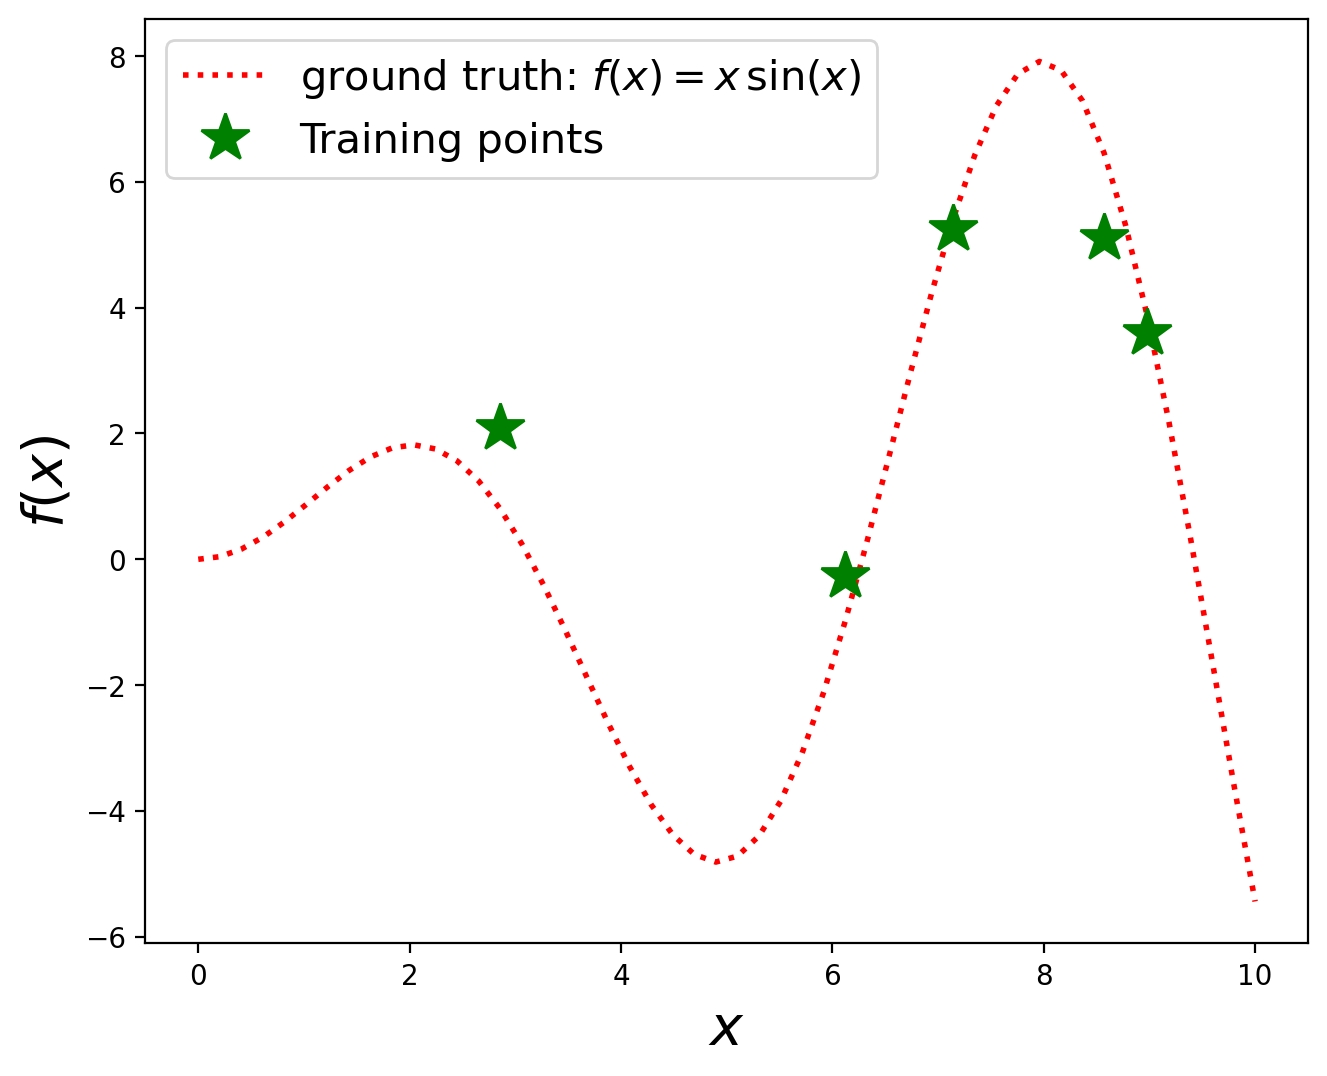

In [11]:
fig3, ax3 = plt.subplots() # This opens a new figure

# Plot the noiseless function ("the ground thruth")
ax3.plot(x_data, y_data, 'r:', linewidth=2, label=u'ground truth: $f(x) = x\,\sin(x)$')
ax3.plot(x_train, y_train, 'g*', markersize=18, label="Training points") # Markers locating training points
ax3.set_xlabel('$x$', fontsize=20) # label of the x axis
ax3.set_ylabel('$f(x)$', fontsize=20) # label of the y axis
ax3.legend(loc='upper left', fontsize=15) # plot legend in the upper left corner
fig3.set_size_inches(7.5, 6) # scale figure to be taller

## In-class Exercise

Fit a polynomial of degree 4 to this training data and calculate the $R^2$ and $\text{MSE}$ metrics for the testing data.

In [12]:
# Write your code for In-class Exercise:

# until here.

Well done...

Yet, this does not seem like a great result, does it?

The $R^2$ value is so bad that it is even negative!

* What explains this result?

* Can we do something to fix this while still using polynomials?

* If we used more points would that help?

* What if we increased the degree of the polynomial?

In Homework 4 you will explore more...

## Multi-dimensional example of Linear Regression

We are now going to try to learn a three-dimensional function named "Schwefel".

In [13]:
# Uncomment line below if you want to enable live rotation of the surface plots.
#%matplotlib notebook
#
from matplotlib import cm # to change colors of surface plots
#
# Let's define the Schwefel function:
def schwefel( x ):
    function_name = 'Schwefel' # to output name of function
    x = np.asarray_chkfinite(x)  # ValueError if any NaN or Inf
    if x.ndim == 1:
        x = np.reshape(x,(-1,2)) # reshape into 2d array
    #
    n_points, n_features = np.shape(x)
    y = np.empty((n_points,1))
    #
    for ii in range(n_points):
        y[ii] = 418.9829*n_features - sum( x[ii,:] * np.sin( np.sqrt( abs( x[ii,:] ))))
    return (np.atleast_1d(y), function_name)

<a id='#create_dataset'></a>

Consider equally spaced sampling points to evaluate the function, as we did before for the 1D case.

In [14]:
# We will also create a grid of points for plotting:
n_points_per_dimension = 50
x1_plot = np.linspace(-10.0, 10.0, n_points_per_dimension)
x2_plot = np.linspace(-10.0, 10.0, n_points_per_dimension)
#
X1_plot, X2_plot = np.meshgrid(x1_plot, x2_plot) # creates a grid of points that is necessary
                                                 # to plot surfaces (note that X1_plot and X2_plot
                                                 # are matrices, instead of vectors)
#
print("Note that the X1_plot (and X2_plot) are 2D arrays with the following size:\n", np.shape(X1_plot))
#
X_plot = np.array([X1_plot, X2_plot]).reshape(2, -1).T # Matrix with points for plotting

Note that the X1_plot (and X2_plot) are 2D arrays with the following size:
 (50, 50)


In [15]:
# Output data created from one of the benchmark functions:
# levy, ackley, rosenbrock, schwefel, griewank, rastrigin
y_plot_true, function_name = schwefel(X_plot) # calculate the output vector y_true (1D output)
                                         # from input data X_plot (2D input)

print("The output of the function is a vector with size:\n", np.shape(y_plot_true))

# Reshape output data for use in Surface plot:
Y_plot_true = np.reshape(y_plot_true,np.shape(X1_plot)) # ground-truth function values for plotting

print("So, we reshape the output vector into a 2D array needed to plot surfaces:\n", np.shape(Y_plot_true))

# Set the color scheme used in every plot:
set_cm = cm.cool # viridis, inferno, copper, PuBu, cool, coolwarm, hsv

The output of the function is a vector with size:
 (2500, 1)
So, we reshape the output vector into a 2D array needed to plot surfaces:
 (50, 50)


Let's plot the function in a few different ways:
* Left subplot: 3D surface of the function
* Right subplot: a wireframe of the surface (no colors)

<a id='#choose_other_function'></a>

Now evaluate the function of interest (Schwefel function) at these input points to plot the "ground-truth" that we want to learn afterwards.

In [16]:
fig3 = plt.figure(figsize=plt.figaspect(0.5)); ax3 = [];
# Subplot 1 (left) of Figure 1
ax3.append(fig3.add_subplot(1, 2, 1, projection='3d')) # just a way to use the same variable for all axes of fig1.
# Surface plot:
surf = ax3[0].plot_surface(X1_plot, X2_plot, Y_plot_true, cmap=set_cm, alpha=0.8, linewidth=0, antialiased=False)
ax3[0].set_xlabel('$x_1$', fontsize=15)
ax3[0].set_ylabel('$x_2$', fontsize=15)
ax3[0].set_zlabel('$f(x_1,x_2)$', fontsize=15)
ax3[0].set_title("%s function" % function_name, fontsize=15)

# Subplot 2 (right) of Figure 1
ax3.append(fig3.add_subplot(1, 2, 2, projection='3d'))
# Plot a 3D wireframe (no colors)
ax3[1].plot_wireframe(X1_plot, X2_plot, Y_plot_true, rstride=5, cstride=5)
ax3[1].set_xlabel('$x_1$', fontsize=15)
ax3[1].set_ylabel('$x_2$', fontsize=15)
ax3[1].set_zlabel('$f(x_1,x_2)$', fontsize=15)
ax3[1].set_title("%s function" % function_name, fontsize=15)
#plt.tight_layout() # if we want to enlarge the figures, but sometimes this leads to label occlusion.
fig3.set_size_inches(15, 6)
plt.close(fig3)

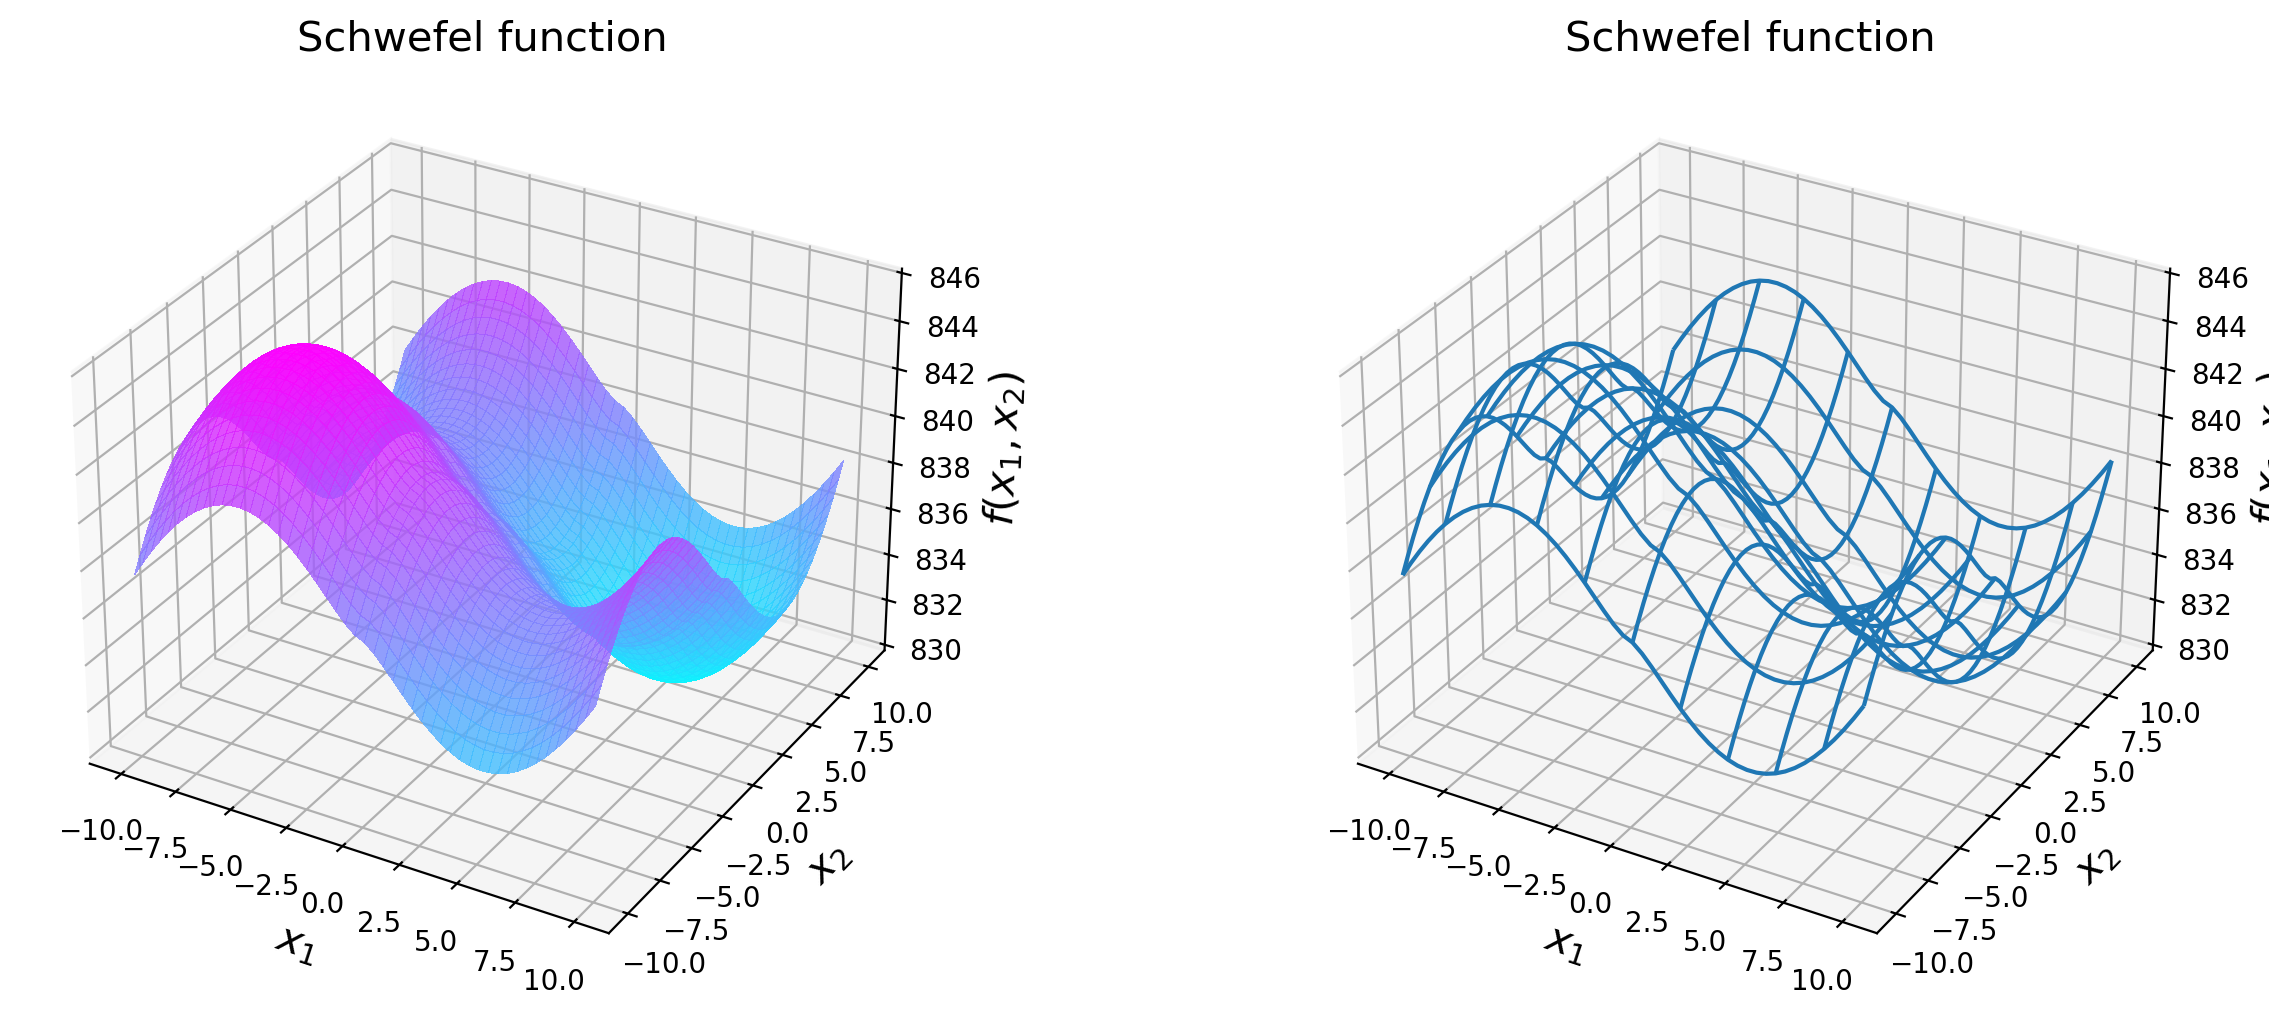

In [17]:
fig3

We can also create a contour plot of the same function.

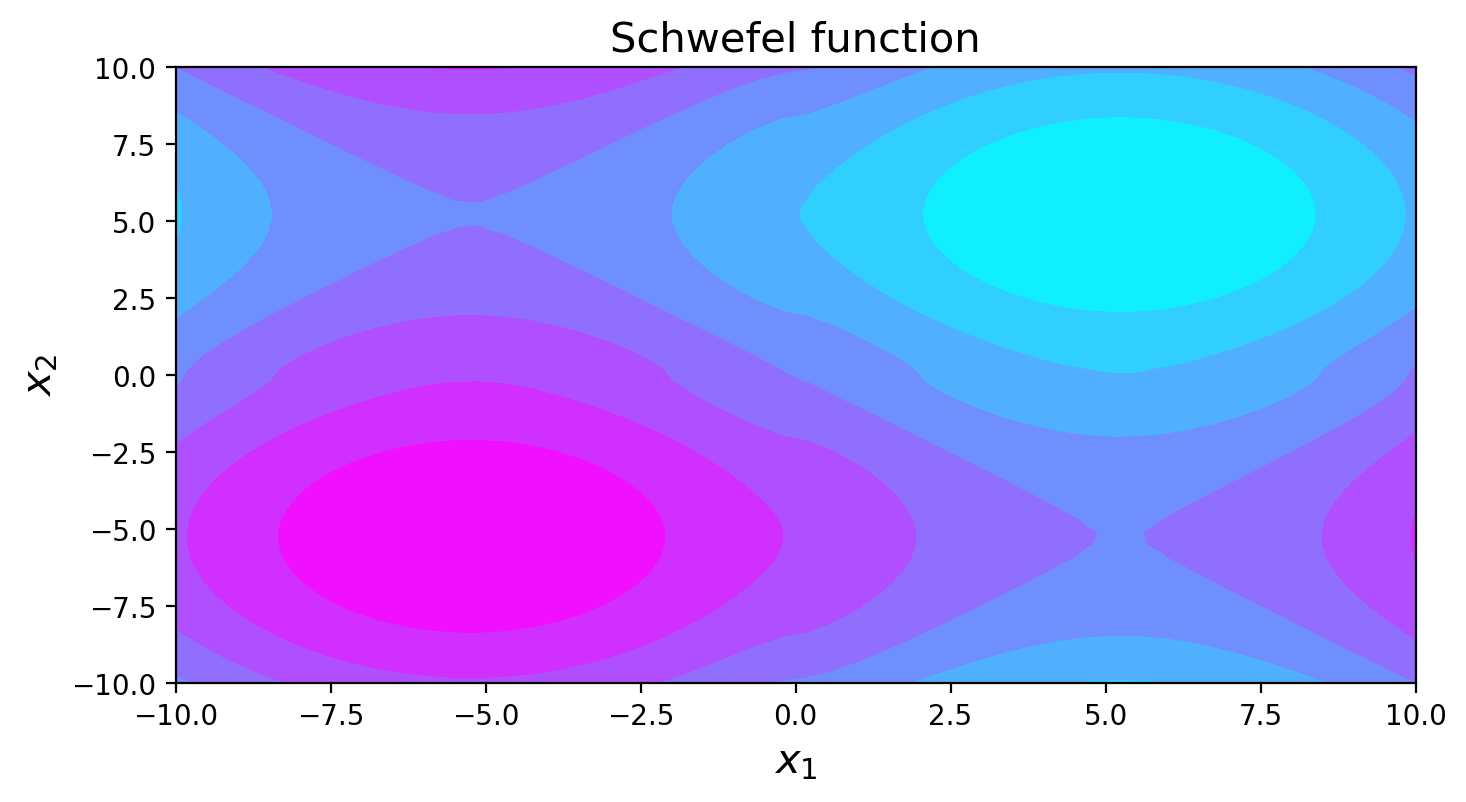

In [18]:
fig4, ax4 = plt.subplots()
cset = ax4.contourf(X1_plot, X2_plot, Y_plot_true, cmap=set_cm)
ax4.set_xlabel('$x_1$', fontsize=15)
ax4.set_ylabel('$x_2$', fontsize=15)
ax4.set_title("%s function" % function_name, fontsize=15)
fig4.colorbar(cset, ax=ax2)

#### Loading Schwefel function data from "../data" folder

* The "docs" folder contains a file called "data_noiseless_schwefel_2D_regression.pkl" with a Pandas DataFrame with data obtained from the Schwefel function in the domain $x \in [-10, 10]$ without considering noise.

So, let's load this DataFrame and use it for training a 2D Linear Regression model

In [19]:
import pandas as pd
df = pd.read_pickle("../data/data_noiseless_schwefel_2D_regression.pkl") # read pandas DataFrame
function_name = 'Schwefel' # The dataframe was created using the Schwefel function

print("Show the DataFrame in the docs folder:\n", df)

Show the DataFrame in the docs folder:
              x1    x2          y1
0    -10.000000 -10.0  837.552129
1     -9.591837 -10.0  838.185887
2     -9.183673 -10.0  838.777493
3     -8.775510 -10.0  839.323512
4     -8.367347 -10.0  839.820614
...         ...   ...         ...
2495   8.367347  10.0  836.110986
2496   8.775510  10.0  836.608088
2497   9.183673  10.0  837.154107
2498   9.591837  10.0  837.745713
2499  10.000000  10.0  838.379471

[2500 rows x 3 columns]


Although we introduced pandas in Lecture 2, you should keep exploring how it works...

For example, there are a few different ways to access the data of a DataFrame.

The notes below (not shown in the presentation), show you 3 different ways:

1. Direct way to select columns & rows by how they were labeled originaly


2. DataFrame.loc to select columns & rows by Name


3. DataFrame.iloc to select columns & rows by Index Positions (integer numbers)

In [20]:
# Let's access every row of feature 'x1' and of target 'y1':
way1 = df[['x1','y1']] # direct way

way2 = df.loc[:,['x1','y1']] # using the labels of rows and columns

way3 = df.iloc[:,[0,2]] # using indices (integers) of rows and columns

print('way 1 =\n', way1, '\n\n') # the '\n' is to make a new line for visualization purposes only.
print('way 2 =\n', way2, '\n\n')
print('way 3 =\n', way3, '\n\n')

way 1 =
              x1          y1
0    -10.000000  837.552129
1     -9.591837  838.185887
2     -9.183673  838.777493
3     -8.775510  839.323512
4     -8.367347  839.820614
...         ...         ...
2495   8.367347  836.110986
2496   8.775510  836.608088
2497   9.183673  837.154107
2498   9.591837  837.745713
2499  10.000000  838.379471

[2500 rows x 2 columns] 


way 2 =
              x1          y1
0    -10.000000  837.552129
1     -9.591837  838.185887
2     -9.183673  838.777493
3     -8.775510  839.323512
4     -8.367347  839.820614
...         ...         ...
2495   8.367347  836.110986
2496   8.775510  836.608088
2497   9.183673  837.154107
2498   9.591837  837.745713
2499  10.000000  838.379471

[2500 rows x 2 columns] 


way 3 =
              x1          y1
0    -10.000000  837.552129
1     -9.591837  838.185887
2     -9.183673  838.777493
3     -8.775510  839.323512
4     -8.367347  839.820614
...         ...         ...
2495   8.367347  836.110986
2496   8.775510  836.

In [21]:
# Now let's access rows 2 until 5 (inclusive) of feature 'x2' an target 'y1':

# I think we can't do that by the direct way (correct me if I am wrong)
way2 = df.loc[2:5,['x2','y1']] # using the labels of data. Note that here when we write 2:5 (it includes)
                               # row with index 5

way3 = df.iloc[2:6,[1,2]] # using indices (integers) of the data note that we write 2:6 to include 5,
                          # which differs from way2 (!).
# way3 = df.iloc[2:6,1:3] # Alternative to accessing 'x2' and 'y1' by writing 1:3 instead of [1,2]

print('Specific rows, way 2 =\n', way2, '\n\n')
print('Specific rows, way 3 =\n', way3, '\n\n')

Specific rows, way 2 =
      x2          y1
2 -10.0  838.777493
3 -10.0  839.323512
4 -10.0  839.820614
5 -10.0  840.265605 


Specific rows, way 3 =
      x2          y1
2 -10.0  838.777493
3 -10.0  839.323512
4 -10.0  839.820614
5 -10.0  840.265605 




In [22]:
# Separate the features and targets into two different variables:
X_data = df.loc[:,['x1','x2']].values # note that we ask for all the values, not a subset of the DataFrame
y_data = df.loc[:,'y1'].values

print("Features loaded from the saved DataFrame:\n", X_data)
print("\nTarget loaded from the saved DataFrame:\n", y_data)

Features loaded from the saved DataFrame:
 [[-10.         -10.        ]
 [ -9.59183673 -10.        ]
 [ -9.18367347 -10.        ]
 ...
 [  9.18367347  10.        ]
 [  9.59183673  10.        ]
 [ 10.          10.        ]]

Target loaded from the saved DataFrame:
 [837.55212937 838.18588668 838.77749275 ... 837.15410725 837.74571332
 838.37947063]


<a id='#split_dataset'></a>

Now that we loaded the dataset, we should split it into training and testing sets (as we did in the beginning of this lecture).

* For now, we split the data with the following ratio: 75% for training set, and 25% for testing set

In [23]:
# Train/test split like we did before!
from sklearn.model_selection import train_test_split

testset_ratio = 0.25 # ratio of test set points from the dataset

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size=testset_ratio,random_state=seed)

Now we can train the Linear Regression model on the training data and test it on the testing data!

Let's use a polynomial of degree 2

In [27]:
degree = 3 # degree of polynomial we want to fit
poly_model_2D = make_pipeline(PolynomialFeatures(degree),LinearRegression())
poly_model_2D.fit(X_train,y_train) # fit the polynomial to our 5 points in x_train
y_pred = poly_model_2D.predict(X_test) # prediction of our polynomial
# Compute MSE and R2 for the polynomial model we fitted
mse_value = mean_squared_error(y_test, y_pred)
r2_value = r2_score(y_test, y_pred)
print('MSE for polynomial = ', mse_value)
print('R2 score for polynomial = ', r2_value)

MSE for polynomial =  0.05384554892703787
R2 score for polynomial =  0.9966957165240836


And now we can plot the result (we will also plot the "ground truth" of the Schwefel function)

In [28]:
fig5 = plt.figure(figsize=plt.figaspect(0.5)); ax5 = []
# Subplot 1 (left): ground truth
ax5.append(fig5.add_subplot(1, 2, 1, projection='3d'))
surf = ax5[0].plot_surface(X1_plot, X2_plot, Y_plot_true,
                                 cmap=set_cm, alpha=0.8, linewidth=0, antialiased=False)
ax5[0].set_xlabel('$x_1$', fontsize=15)
ax5[0].set_ylabel('$x_2$', fontsize=15)
ax5[0].set_zlabel('$f(x_1,x_2)$', fontsize=15)
ax5[0].set_title("Ground truth of %s function" % function_name, fontsize=15)

# Subplot 2 (right): Linear Regression approximation
ax5.append(fig5.add_subplot(1, 2, 2, projection='3d'))
y_plot_pred = poly_model_2D.predict(X_plot) # prediction of our polynomial for the points used for plotting
Y_plot_pred = np.reshape(y_plot_pred,np.shape(X1_plot)) # convert targets into grid format for plotting
surf = ax5[1].plot_surface(X1_plot, X2_plot, Y_plot_pred,
                           cmap=set_cm, alpha=0.8, linewidth=0, antialiased=False)
ax5[1].set_xlabel('$x_1$', fontsize=15)
ax5[1].set_ylabel('$x_2$', fontsize=15)
ax5[1].set_zlabel('$f(x_1,x_2)$', fontsize=15)
ax5[1].set_title("Approximation with Linear Regression Model of degree %s" % degree, fontsize=15)
ax5[1].scatter(X_train[:,0], X_train[:,1], y_train, marker='o', color='red', label="training points")
ax5[1].legend(loc='upper center')
#plt.tight_layout()
fig5.set_size_inches(15, 6)
plt.close(fig5) # close figure to open it in next cell.

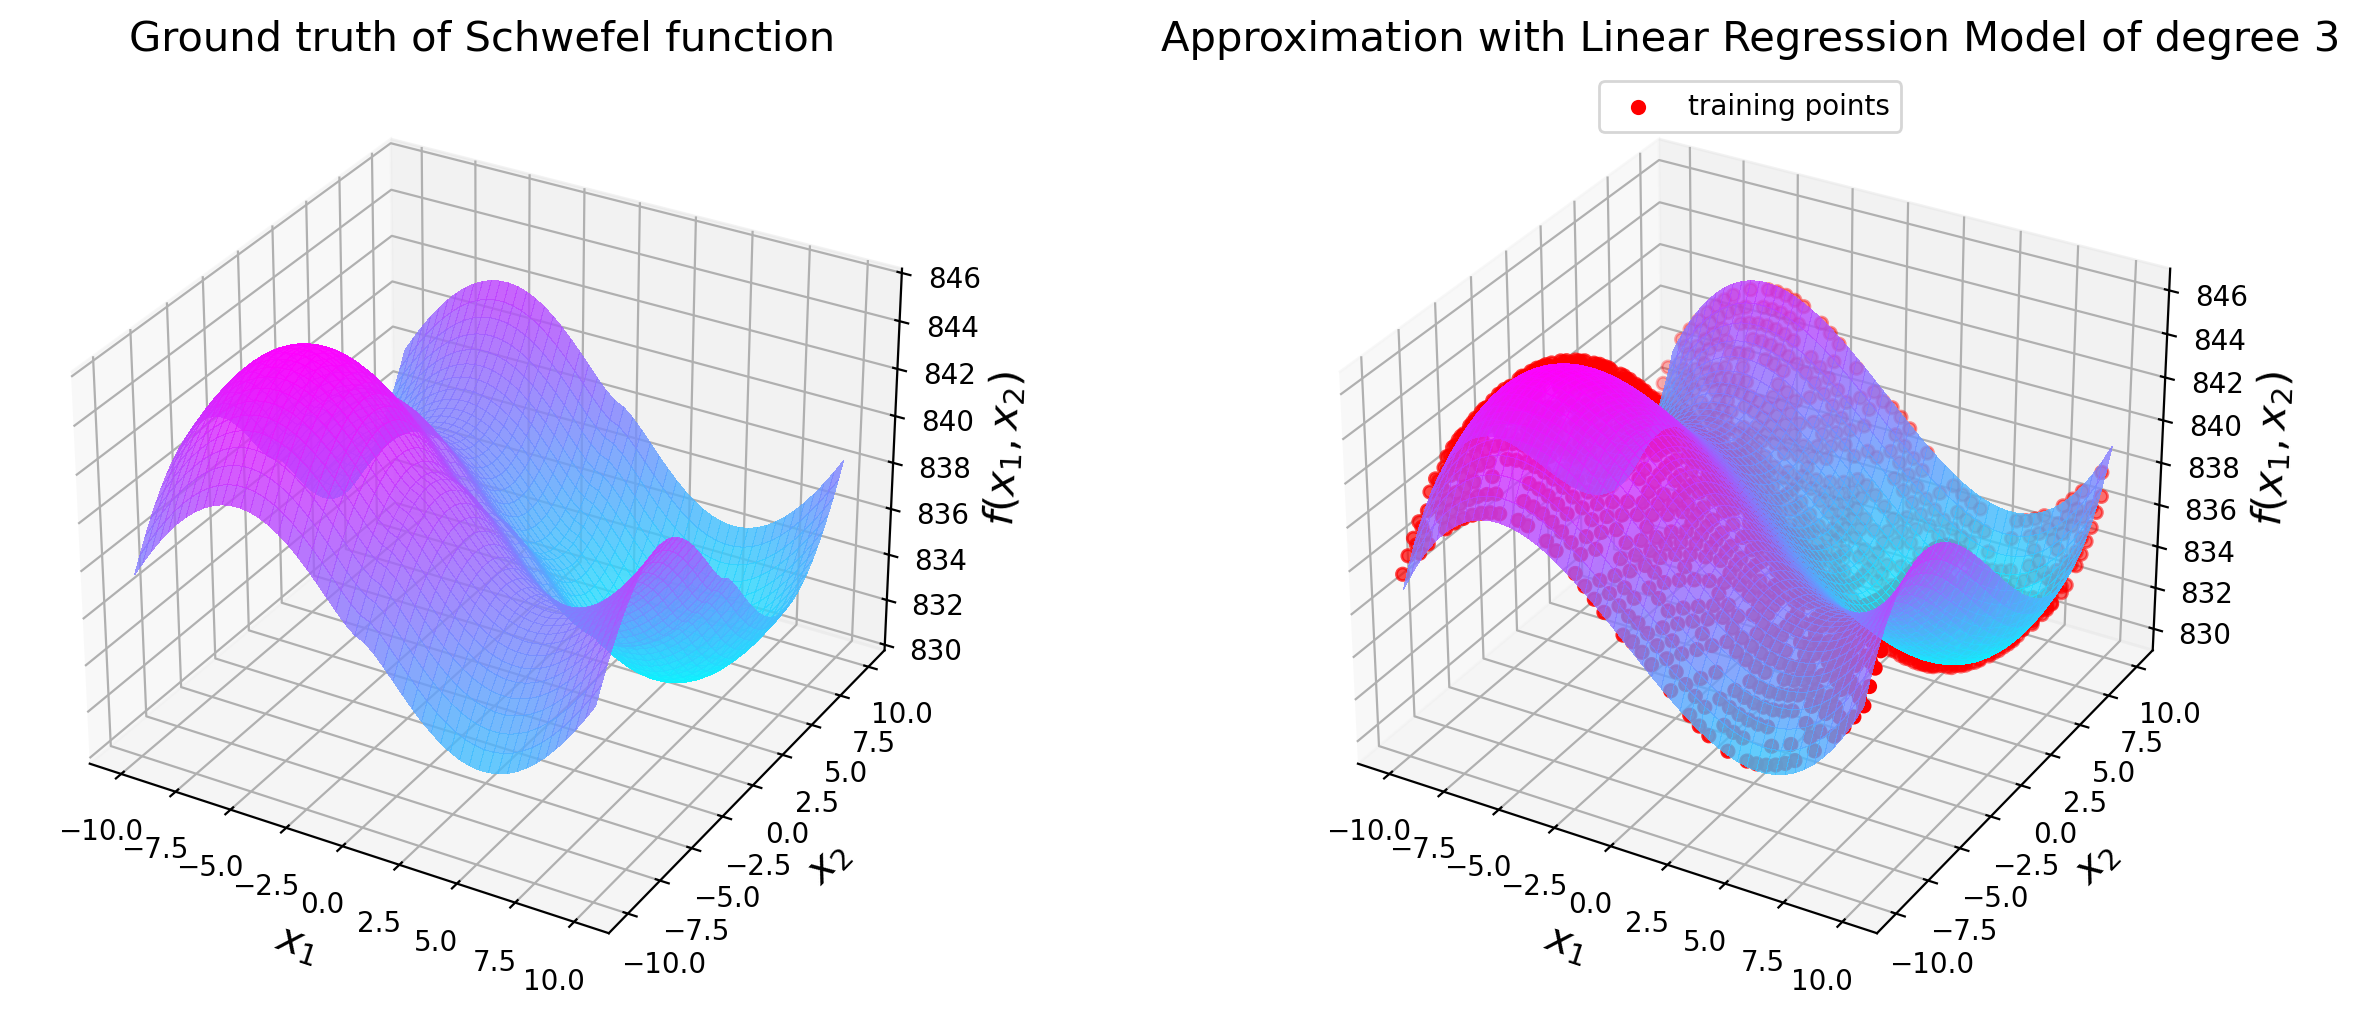

In [29]:
fig5 # show figure

## In-class Exercise

1. Go back and train a polynomial of degree 3. You will get a much better approximation and a nicely looking plot!


2. Go back and train a polynomial of degree 20. You will get a pretty bad prediction...

In Homework 4 you will explore more this and other aspects of Linear Regression.

### See you next class

Have fun!

## Solution to In-class Exercise

``` python
degree = 4 # degree of polynomial we want to fit
poly_model2 = make_pipeline(PolynomialFeatures(degree),LinearRegression())
poly_model2.fit(X_train,y_train) # fit the polynomial to our 5 points in x_train
y_pred = poly_model2.predict(X_data) # prediction of our polynomial
# Compute MSE and R2 for the polynomial model we fitted
mse_value = mean_squared_error(y_noisy_data, y_pred)
r2_value = r2_score(y_noisy_data, y_pred)
print('MSE for polynomial = ', mse_value)
print('R2 score for polynomial = ', r2_value)
# Then, plot the polynomial prediction on top of fig1:
ax3.plot(x_data, y_pred, 'bo-', markersize=6, linewidth=2, label="Polynomial of degree %d prediction" % degree)
# Replot figure and legend:
ax3.legend(loc='upper right')
fig3
```